In [1]:
from headers import *

In [29]:
class DMP():
	
	def __init__(self,time_steps=100):

		self.alphaz = 25.0
		self.betaz = self.alphaz/4
		self.alpha = 1*self.alphaz/3    
        
		self.time_steps = time_steps
		self.tau = self.time_steps

		self.dimensions = 2
		self.number_kernels = 100
		self.gaussian_kernels = npy.zeros((self.number_kernels,2))

		self.weights = npy.zeros((self.number_kernels, self.dimensions))

		self.demo_pos = npy.zeros((self.time_steps, self.dimensions))
		self.demo_vel = npy.zeros((self.time_steps, self.dimensions))
		self.demo_acc = npy.zeros((self.time_steps, self.dimensions))

		self.target_forces = npy.zeros((self.time_steps, self.dimensions))        
		self.phi = npy.zeros((self.number_kernels, self.time_steps, self.time_steps))
		self.eta = npy.zeros((self.time_steps, self.dimensions))
		self.vector_phase = npy.zeros(self.time_steps)
        
# Defining Rollout variables.
		self.rollout_time = self.time_steps
		self.dt = 1./self.rollout_time
		self.pos_roll = npy.zeros((self.rollout_time,self.dimensions))
		self.vel_roll = npy.zeros((self.rollout_time,self.dimensions))
		self.acc_roll = npy.zeros((self.rollout_time,self.dimensions))
		self.force_roll = npy.zeros((self.rollout_time,self.dimensions))        
		self.pos_var = npy.zeros(self.dimensions)
		self.vel_var = npy.zeros(self.dimensions)
		self.acc_var = npy.zeros(self.dimensions)        
		self.force_var = npy.zeros(self.dimensions)        
		self.goal = npy.zeros(self.dimensions)
		self.start = npy.zeros(self.dimensions)        

	def load_trajectory(self,pos,vel,acc):
		self.demo_pos = copy.deepcopy(pos)
		self.demo_vel = copy.deepcopy(vel)
		self.demo_acc = copy.deepcopy(acc)

	def initialize_variables(self):	
		self.weights = npy.zeros((self.number_kernels, self.dimensions))
		self.target_forces = npy.zeros((self.time_steps, self.dimensions))
		self.phi = npy.zeros((self.number_kernels, self.time_steps, self.time_steps))
		self.eta = npy.zeros((self.time_steps, self.dimensions))

		t_range = npy.linspace(0,self.time_steps,self.number_kernels)
# 		t_range_2 = npy.linspace(0,self.time_steps,self.time_steps)        
		self.vector_phase = self.calc_vector_phase(t_range)
		self.gaussian_kernels[:,0] = self.vector_phase
        
# Experiment with the variance of the Guassian Kernels.
# Higher variance helps reach the target values more accurately. 
# The rolled out trajectory is worse. 

# 		self.gaussian_kernels[:,1] = self.number_kernels/self.gaussian_kernels[:,0]       
		dummy = (npy.diff(self.gaussian_kernels[:,0]*2))**2        
# 		dummy = (npy.diff(self.gaussian_kernels[:,0]*0.05))**2            
		self.gaussian_kernels[:,1] = 1. / npy.append(dummy,dummy[-1])

	def calc_phase(self,time):
		return npy.exp(-self.alpha*float(time)/self.tau)
    
	def calc_vector_phase(self,time):
		return npy.exp(-self.alpha*time.astype(float)/self.tau)

	def basis(self,index,time):
		return npy.exp(-(self.gaussian_kernels[index,1])*((self.calc_phase(time)-self.gaussian_kernels[index,0])**2))

	def update_target_force(self):
		self.target_forces = self.demo_acc - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.demo_vel)
    
  	def update_target_force_itau(self):
		self.target_forces = (self.tau**2)*self.demo_acc - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.tau*self.demo_vel)
        
  	def update_target_force_dtau(self):
		self.target_forces = self.demo_acc/(self.tau**2) - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.demo_vel/self.tau)    

	def update_phi(self):		
		for i in range(self.number_kernels):
			for t in range(self.time_steps):
				self.phi[i,t,t] = self.basis(i,t)                
                
	def update_eta(self):        
		t_range = npy.linspace(0,self.time_steps,self.time_steps)        
		vector_phase = self.calc_vector_phase(t_range)        
		self.eta[:,0] = vector_phase*(self.demo_pos[self.time_steps-1,0]-self.demo_pos[0,0])
		self.eta[:,1] = vector_phase*(self.demo_pos[self.time_steps-1,1]-self.demo_pos[0,1])

	def learn_DMP(self):	
# 		self.update_target_force()        
		self.update_phi()
		self.update_eta()

		for j in range(self.dimensions):
			for i in range(self.number_kernels):
				self.weights[i,j] = npy.dot(self.eta[:,j],npy.dot(self.phi[i],self.target_forces[:,j]))
				self.weights[i,j] /= npy.dot(self.eta[:,j],npy.dot(self.phi[i],self.eta[:,j]))

	def save_DMP_parameters(self,file_suffix):

		with file("force_weights_{0}.npy".format(file_suffix),'w') as outfile:
			npy.save(outfile,self.weights)
	
		with file("position_{0}.npy".format(file_suffix),'w') as outfile:
			npy.save(outfile, self.demo_pos)
            
	def shebang(self,pos,vel,acc):
		dmp.load_trajectory(pos,vel,acc)
		dmp.initialize_variables()
		dmp.learn_DMP() 
        
	def initialize_rollout(self,start,goal):
		self.tau = 1
		self.pos_var = copy.deepcopy(start)
		self.pos_roll[0] = copy.deepcopy(start)
		self.vel_var = npy.zeros(self.dimensions)
		self.vel_roll = npy.zeros((self.rollout_time,self.dimensions))        
		self.goal = goal
		self.start = start
		self.dt = 1./self.rollout_time    

	def calc_rollout_force(self,roll_time):
		den = 0        
		time = float(roll_time)/self.rollout_time           
# 		print(roll_time,time,self.calc_phase(time),self.tau)
		for i in range(self.number_kernels):
			self.force_roll[roll_time] += self.basis(i,time)*self.weights[i]
			den += self.basis(i,time)
		self.force_roll[roll_time] *= (self.goal-self.pos_roll[0])*self.calc_phase(time)/den
            
	def calc_rollout_acceleration(self,time):        
		self.acc_var = (1/self.tau**2)*(self.alphaz * (self.betaz * (self.goal - self.pos_var) - self.tau*self.vel_var) + self.force_roll[time])
		self.acc_roll[time] = copy.deepcopy(self.acc_var)
        
	def calc_rollout_vel(self,time):
		self.vel_var += (1/self.tau)*self.acc_var*self.dt
		self.vel_roll[time] = copy.deepcopy(self.vel_var)

	def calc_rollout_pos(self,time):
# 		self.pos_var += self.vel_var * self.dt 
		self.pos_var += self.vel_var * self.dt + 0.5 * self.acc_var *(self.dt**2)        
		self.pos_roll[time] = copy.deepcopy(self.pos_var)

	def rollout(self,start,goal):

		# For all time: 
		self.initialize_rollout(start,goal)
		for i in range(self.rollout_time):        
			self.calc_rollout_force(i)
			self.calc_rollout_acceleration(i)
			self.calc_rollout_vel(i)
			self.calc_rollout_pos(i)   

In [30]:
pwd

u'/home/tanmay/Research/Code/ActionPrimitives'

In [31]:
number_trajectories = 20
dpos = npy.zeros((20,1000,2))
dvel = npy.zeros((20,1000,2))
dacc = npy.zeros((20,1000,2))
dforce = npy.zeros((20,1000,2))
pos = npy.zeros((20,1000,2))
vel = npy.zeros((20,1000,2))
acc = npy.zeros((20,1000,2))
force = npy.zeros((20,1000,2))

for i in range(20):
    dpos[i] = npy.load("Data/Mouse_Data_New/Trajectory_Rollouts/roll_pos_{0}.npy".format(i))    
    dvel[i] = npy.load("Data/Mouse_Data_New/Trajectory_Rollouts/roll_vel_{0}.npy".format(i))
    dacc[i] = npy.load("Data/Mouse_Data_New/Trajectory_Rollouts/roll_acc_{0}.npy".format(i))
    dforce[i] = npy.load("Data/Mouse_Data_New/Trajectory_Rollouts/roll_force_{0}.npy".format(i))
    pos[i] = npy.load("Data/Mouse_Data_New/Traj_{0}/pos_{0}.npy".format(i))  
    vel[i] = npy.load("Data/Mouse_Data_New/Traj_{0}/vel_{0}.npy".format(i))  
    acc[i] = npy.load("Data/Mouse_Data_New/Traj_{0}/acc_{0}.npy".format(i))  
    force[i] = npy.load("Data/Mouse_Data_New/Trajectory_Rollouts/target_force_{0}.npy".format(i))  


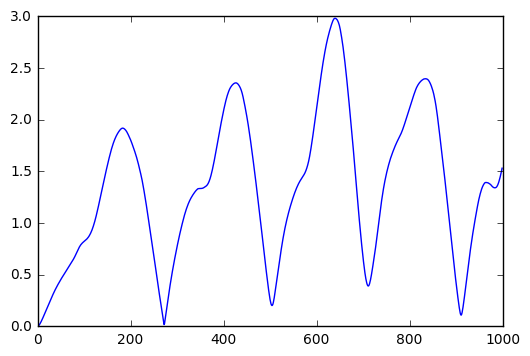

In [32]:
norm_vel = npy.linalg.norm(dvel[0],axis=1)
plt.plot(range(1000),norm_vel)
plt.show()

In [33]:
i1 = 5
min_index = npy.argmin(norm_vel[5:])+i1

In [34]:
pos1 = pos[0,0:min_index]
vel1 = vel[0,0:min_index]
acc1 = acc[0,0:min_index]
pos2 = pos[0,min_index:]
vel2 = vel[0,min_index:]
acc2 = acc[0,min_index:]

In [35]:
dmp1 = DMP(min_index-0)
dmp2 = DMP(pos[0].shape[0]-min_index)

In [36]:
dmp1.load_trajectory(pos1,vel1,acc1)
dmp1.initialize_variables()
dmp1.update_target_force_dtau()
dmp1.learn_DMP()

dmp2.load_trajectory(pos2,vel2,acc2)
dmp2.initialize_variables()
dmp2.update_target_force_dtau()
dmp2.learn_DMP()

In [37]:
start = npy.zeros(2)
goal = npy.ones(2)

dmp1.rollout(start, goal)
dmp2.rollout(start, goal)

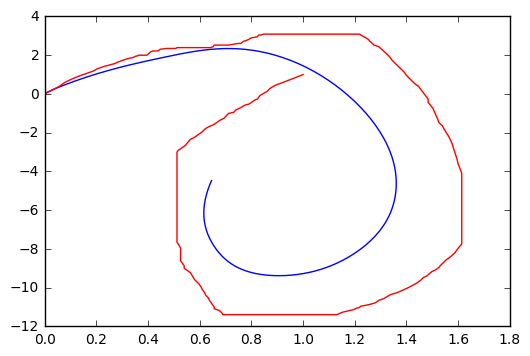

In [40]:
# Also add normalized pos1. 
norm_pos1 = copy.deepcopy(pos1)
norm_pos1 -= norm_pos1[0]
norm_pos1 /= norm_pos1[-1]

plt.plot(dmp1.pos_roll[:,0],dmp1.pos_roll[:,1],'b')
plt.plot(norm_pos1[:,0],norm_pos1[:,1],'r')
plt.show()

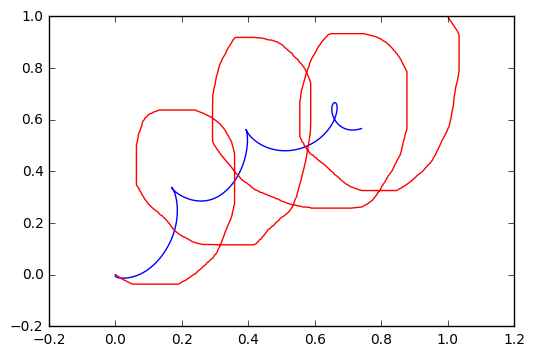

In [41]:
norm_pos2 = copy.deepcopy(pos2)
norm_pos2 -= norm_pos2[0]
norm_pos2 /= norm_pos2[-1]

plt.plot(dmp2.pos_roll[:,0],dmp2.pos_roll[:,1])
plt.plot(norm_pos2[:,0],norm_pos2[:,1],'r')
plt.show()

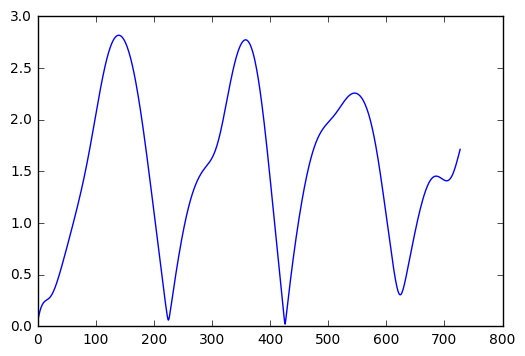

In [49]:
norm_vel_dmp2 = npy.linalg.norm(dmp2.vel_roll,axis=1)
plt.plot(range(dmp2.vel_roll.shape[0]),norm_vel_dmp2)
plt.show()

i1 = 5
min_index_2 = npy.argmin(norm_vel_dmp2[i1:])+i1

In [51]:
pos3 = pos2[0:min_index_2]
vel3 = vel2[0:min_index_2]
acc3 = acc2[0:min_index_2]
pos4 = pos2[min_index_2:]
vel4 = vel2[min_index_2:]
acc4 = acc2[min_index_2:]


In [57]:
dmp3 = DMP(min_index_2-0)
dmp3.load_trajectory(pos3,vel3,acc3)
dmp3.initialize_variables()
dmp3.update_target_force_dtau()
dmp3.learn_DMP()

dmp4 = DMP(pos2.shape[0]-min_index_2)
dmp4.load_trajectory(pos4,vel4,acc4)
dmp4.initialize_variables()
dmp4.update_target_force_dtau()
dmp4.learn_DMP()

In [58]:
dmp3.rollout(start, goal)
dmp4.rollout(start, goal)

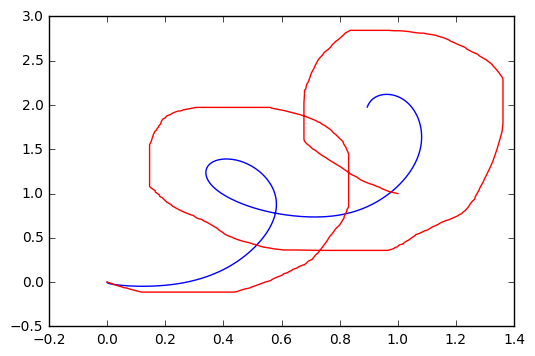

In [59]:
norm_pos3 = copy.deepcopy(pos3)
norm_pos3 -= norm_pos3[0]
norm_pos3 /= norm_pos3[-1]

plt.plot(dmp3.pos_roll[:,0],dmp3.pos_roll[:,1],'b')
plt.plot(norm_pos3[:,0],norm_pos3[:,1],'r')
plt.show()

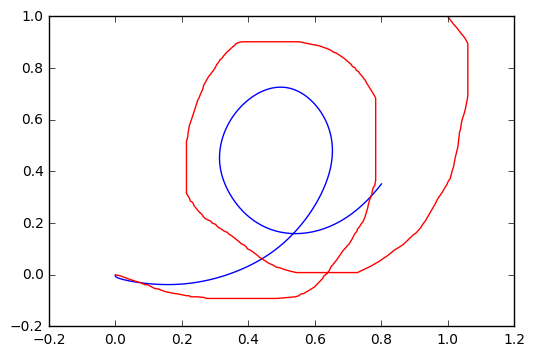

In [60]:
norm_pos4 = copy.deepcopy(pos4)
norm_pos4 -= norm_pos4[0]
norm_pos4 /= norm_pos4[-1]

plt.plot(dmp4.pos_roll[:,0],dmp4.pos_roll[:,1],'b')
plt.plot(norm_pos4[:,0],norm_pos4[:,1],'r')
plt.show()